# 1. Import Libraries

In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

# 2. Path and Parameter for Model

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# 3. Data Augumentation

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# 4. Data Count

In [5]:
import os
import pandas as pd
from IPython.core.display import HTML

def count_exp(path, set_):
    dict_ = {}
    if not os.path.exists(path):
        raise ValueError(f"Path does not exist: {path}")
    
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)  # Use os.path.join for cross-platform compatibility
        if os.path.isdir(dir_):  # Ensure it's a directory
            dict_[expression] = len(os.listdir(dir_))
    
    return pd.DataFrame(dict_, index=[set_])

# Ensure train_dir and test_dir are correctly defined
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

# Fix the append issue
HTML(pd.concat([train_count, test_count]).to_html(escape=False))


,surprise,fear,angry,neutral,sad,disgust,happy
train,3171,4097,3995,4965,4830,436,7215
test,831,1024,958,1233,1247,111,1774


In [6]:
class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


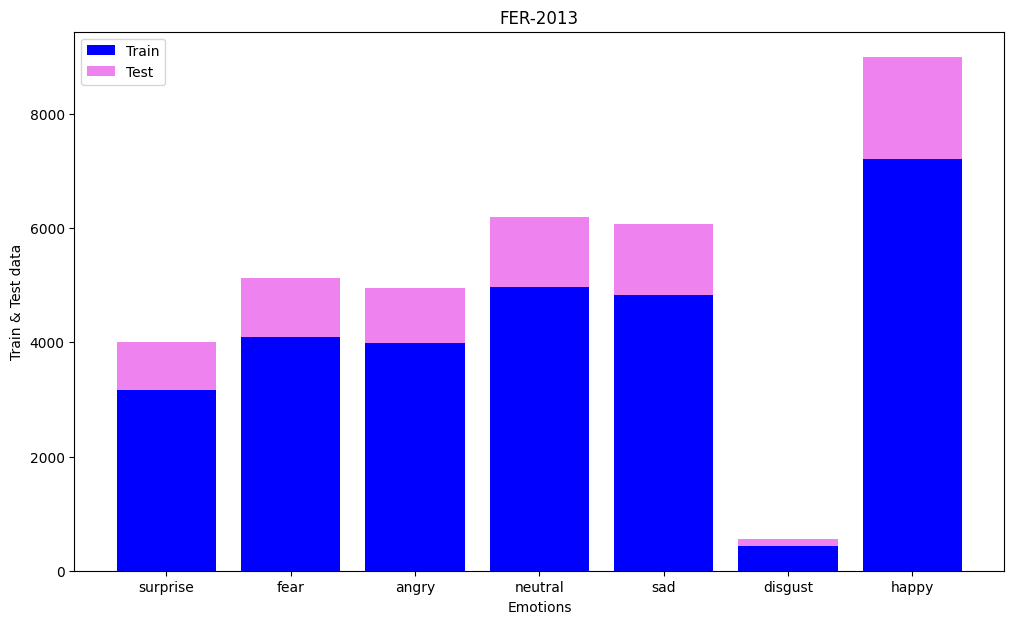

In [8]:
x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

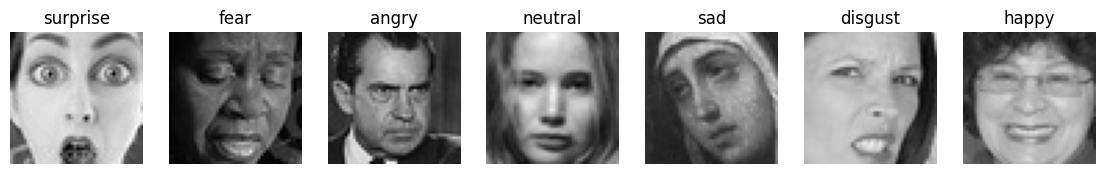

In [9]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# 5. Model

In [10]:
base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
for layer in base_model.layers[:11]:
    layer.trainable=False

In [12]:
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,883,399 (56.78 MB)

 Trainable params: 13,146,119 (50.15 MB)

 Non-trainable params: 1,737,280 (6.63 MB)

In [13]:
print("Model trainable",len(model.trainable_variables))

Model trainable 24


In [14]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [15]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.keras')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 199s 412ms/step - accuracy: 0.8083 - auc: 0.5260 - f1_score: 0.1201 - loss: 5.8453 - precision: 0.1752 - recall: 0.0916 - val_accuracy: 0.8443 - val_auc: 0.6581 - val_f1_score: 0.1085 - val_loss: 2.5654 - val_precision: 0.2993 - val_recall: 0.0669 - learning_rate: 1.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 57s 125ms/step - accuracy: 0.8312 - auc: 0.6045 - f1_score: 0.1620 - loss: 4.6971 - precision: 0.2790 - recall: 0.1148 - val_accuracy: 0.7782 - val_auc: 0.5736 - val_f1_score: 0.1796 - val_loss: 4.1281 - val_precision: 0.1903 - val_recall: 0.1698 - learning_rate: 1.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 57s 126ms/step - accuracy: 0.8419 - auc: 0.6336 - f1_score: 0.1789 - loss: 4.2930 - precision: 0.3469 - recall: 0.1211 - val_accuracy: 0.8574 - val_auc: 0.7342 - val_f1_score: 0.3387 - val_loss: 2.3043 - val_precision: 0.5021 - val_recall: 0.2551 - learning_rate: 1.0000e-04
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accur

# 6 Evaluate Model

**6.1 Check Score for both train and test**

In [16]:
train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.9751 - auc: 0.9930 - f1_score: 0.9115 - loss: 0.3530 - precision: 0.9248 - recall: 0.8987
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9005 - auc: 0.9014 - f1_score: 0.6423 - loss: 1.4383 - precision: 0.6601 - recall: 0.6257


In [17]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate
0,Loss,0.350,1.426
1,Accuracy,0.975,0.901
2,Precision,0.926,0.663
3,Recall,0.899,0.627
4,Auc,0.993,0.900
5,F1_Score,0.912,0.645


**6.2 Visualization**

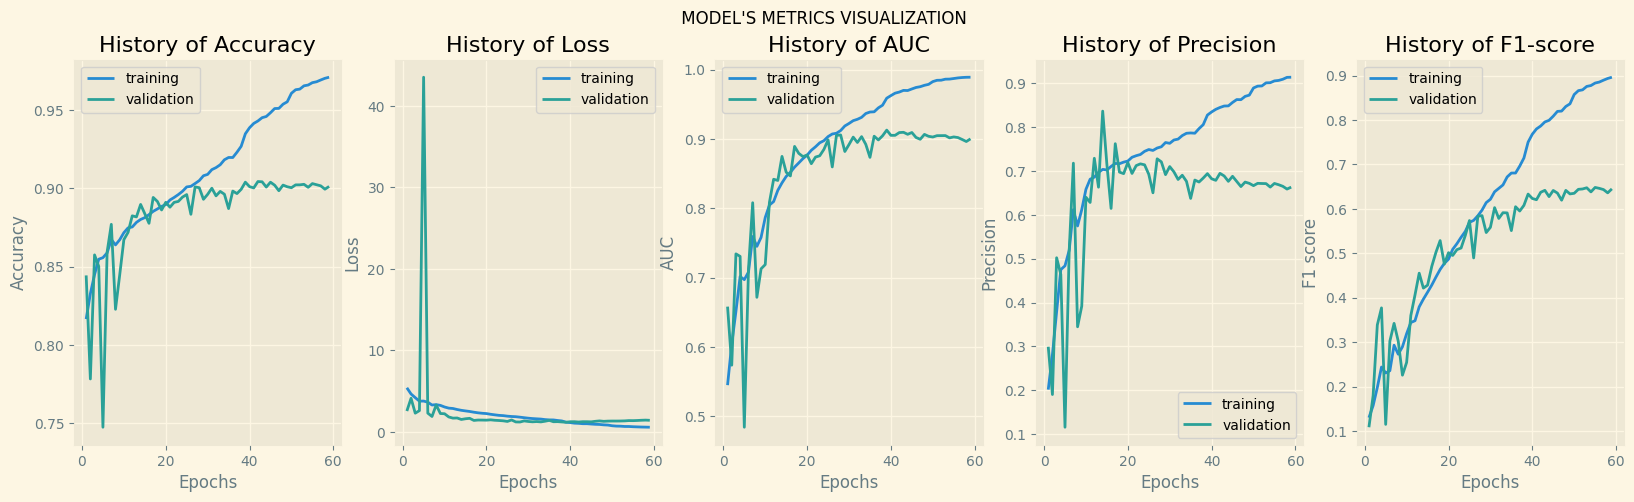

In [18]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

**6.3 Confusion Matrix**

In [19]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step


<ipython-input-20-a56f347fa47c>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


Confusion matrix, without normalization

[[147   9 114 209 204 165 110]
 [ 18   0  10  27  18  19  19]
 [163  15 135 214 200 186 111]
 [252  22 232 403 321 334 210]
 [166  18 162 301 217 215 154]
 [171  18 156 290 227 235 150]
 [134   8 104 180 165 151  89]]





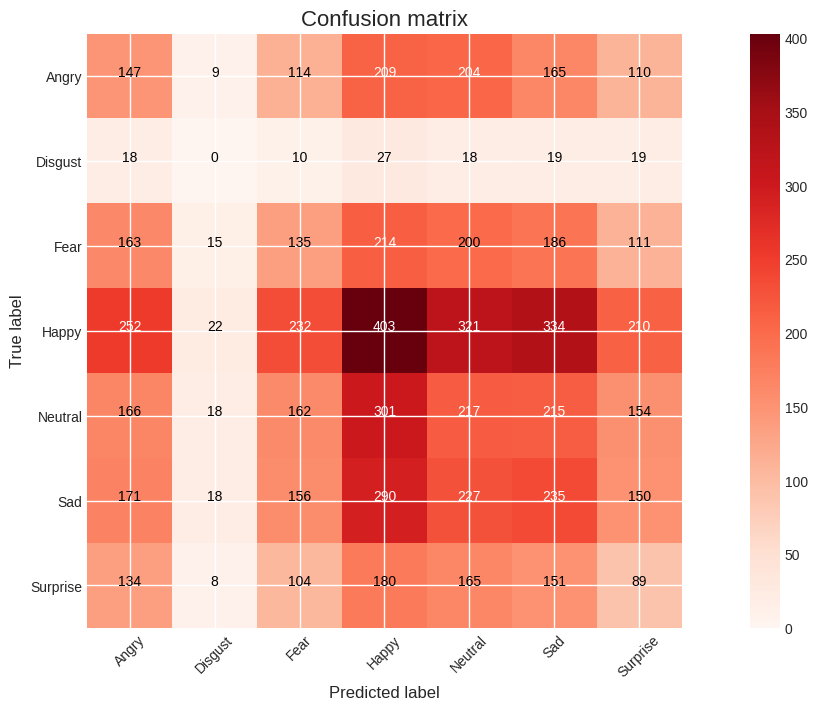

In [20]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<ipython-input-21-e68e0cb2e8fd>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


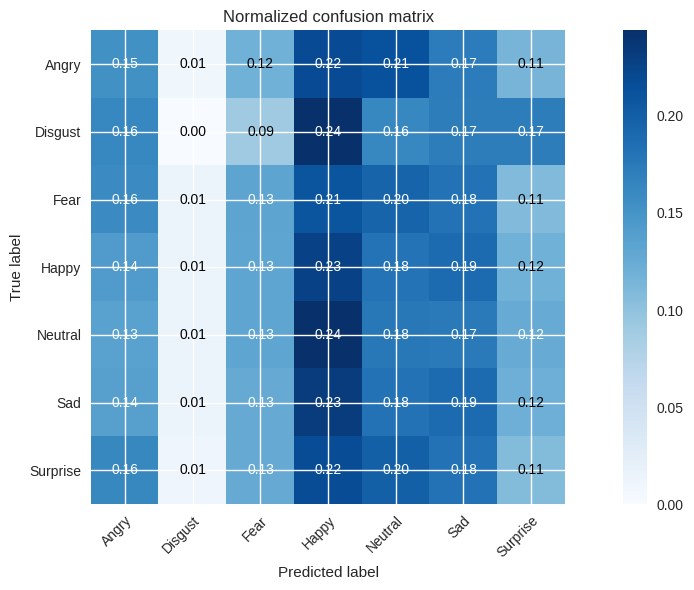

In [21]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# 7. Model Saving

In [22]:
model.save("/kaggle/working/VGG16_Model.h5")

# 8. Testing

(48, 48, 1)


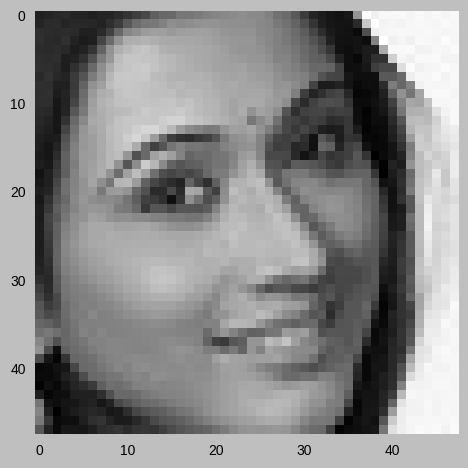

In [23]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='../input/fer2013/test/happy/PrivateTest_3333329.jpg'
test_image=image.load_img(img_path,target_size= IMAGE_SIZE,color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [24]:
img=image.load_img(img_path,target_size=IMAGE_SIZE)
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [25]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
[0. 0. 0. 1. 0. 0. 0.]
The person facial emotion is: Happy
